# Cluster characterization

In this notebook, we explore the characteristics of clusters from the Helios trace.

In [1]:
"""
Note that only the `Venus` trace is public available now. 
Other traces are being censored. We will release them as soon as possible.
"""
# cluster_list = ["Venus", "Earth", "Saturn", "Uranus"]
cluster_list = ["Venus"]

In [2]:
from datetime import timedelta

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from matplotlib.lines import Line2D
from pylab import *

matplotlib.font_manager._rebuild()

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()


def load_data(cluster, opt):
    """Data Loading & Processing"""
    if opt == "seq":
        df = pd.read_csv(
            f"../../data/{cluster}/cluster_sequence.csv",
            parse_dates=["time"],
            index_col="time",
        )
    elif opt == "tp":
        df = pd.read_csv(
            f"../../data/{cluster}/cluster_throughput.csv",
            parse_dates=["time"],
            index_col="time",
        )
    elif opt == "log":
        df = pd.read_csv(
            f"../../data/{cluster}/cluster_log.csv",
            parse_dates=["submit_time", "start_time", "end_time"],
        )
    else:
        raise ValueError("Please check opt")

    return df

## Diurnal Trends of Cluster Usage

Diurnal pattern of the clusters in Helios. 

(a) Hourly average cluster utilization of each cluster over six months.

(b) Hourly average GPU job submission rates of each cluster over six months.

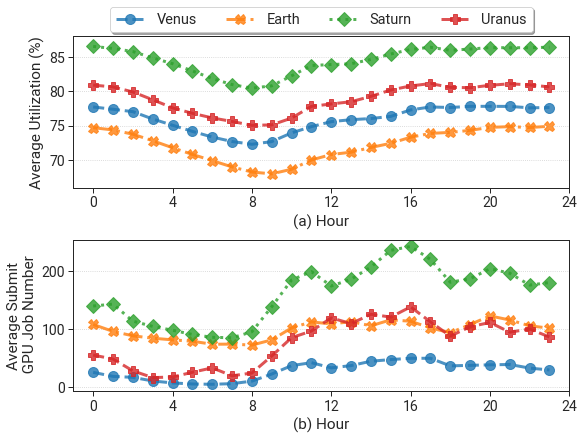

In [3]:
def cluster_diurnal_utilization_tp(cluster_list, save=False):
    fig, (ax1, ax2) = plt.subplots(
        ncols=1, nrows=2, constrained_layout=True, figsize=(8, 6)
    )
    linestyles = ["--o", "-.X", ":D", "--P"]
    for k in range(0, len(cluster_list)):
        day_util_mean = []
        seq = load_data(cluster_list[k], "seq")
        for i in range(0, 24):
            day_util_mean.append(
                seq[seq.index.hour == i]["gpu_utilization"].agg("mean")
            )
        ax1.plot(
            arange(0, 24),
            [i * 100 for i in day_util_mean],
            linestyles[k],
            alpha=0.8,
            label=cluster_list[k],
        )

    ax1.set_xlabel(f"(a) Hour")
    ax1.set_ylabel(f"Average Utilization (%)")
    ax1.set_xticks(arange(0, 25, 4))
    ax1.set_xlim(-1, 24)
    ax1.set_ylim(66, 88)
    ax1.grid(axis="y", linestyle=":")
    ax1.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.24),
        ncol=4,
        fancybox=True,
        shadow=True,
        fontsize=14.5,
    )

    for k in range(0, len(cluster_list)):
        tp = load_data(cluster_list[k], "tp")
        tp = tp.resample("H").sum()
        day_sub_mean = []
        for i in range(0, 24):
            day_sub_mean.append(tp[tp.index.hour == i]["submit_gpu_job"].agg("mean"))

        ax2.plot(
            arange(0, 24), day_sub_mean, linestyles[k], alpha=0.8, label=cluster_list[k]
        )

    ax2.set_xlabel(f"(b) Hour")
    ax2.set_ylabel(f"Average Submit\n GPU Job Number")
    ax2.set_xticks(arange(0, 25, 4))
    ax2.grid(axis="y", linestyle=":")
    ax2.set_xlim(-1, 24)

    if save:
        fig.savefig(f"./cluster_diurnal.pdf", bbox_inches="tight", dpi=600)


cluster_diurnal_utilization_tp(cluster_list, save=True)

## Monthly Trends of Cluster Usage

Monthly trends of cluster activities in Helios. 

Bars: number of submitted GPU jobs in each month in 2020. Bottom striped part represents multi-GPU job number and top part indicates single-GPU job number. 

Dashed Lines: average cluster utilization in each month.

Note we use the same color for the bar and dashed line to denote the same cluster.

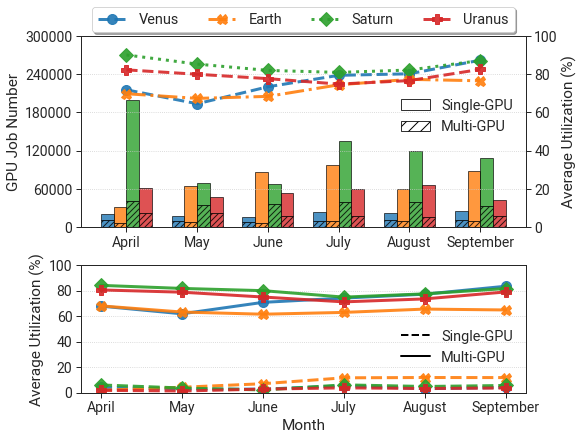

In [4]:
def monthly_util(cluster_list, save):
    fig, (ax1, ax2) = plt.subplots(
        ncols=1,
        nrows=2,
        gridspec_kw={"height_ratios": [1.5, 1]},
        constrained_layout=True,
        figsize=(8, 6),
    )
    cmap = plt.get_cmap("tab10")

    df = pd.read_csv("../../data/all_cluster_monthly_job_num.csv", index_col="id")
    x = np.arange(1, 7)
    width = 0.18

    jobnumL = pd.DataFrame()
    jobnumG = pd.DataFrame()
    for m in range(4, 10):
        jobnumL = pd.concat([jobnumL, df[str(m) + " GJobNum 1"]], axis=1)
        jobnumG = pd.concat([jobnumG, df[str(m) + " GJobNum g1"]], axis=1)

    for i in range(len(jobnumL)):
        offset = i - 1.5
        p1 = ax1.bar(
            x + offset * width,
            jobnumG.iloc[i],
            width,
            alpha=0.8,
            linewidth=0.8,
            edgecolor="k",
            label=jobnumG.index[i],
            color=cmap(i),
            hatch="////",
        )

        p2 = ax1.bar(
            x + offset * width,
            jobnumL.iloc[i],
            width,
            bottom=jobnumG.iloc[i],
            alpha=0.8,
            linewidth=0.8,
            edgecolor="k",
            label=jobnumL.index[i],
            color=cmap(i),
            # hatch="//"
        )
        A = mpatches.Patch(facecolor="white", edgecolor="black", label="Single-GPU")
        B = mpatches.Patch(
            facecolor="white", edgecolor="black", hatch="//", label="Multi-GPU"
        )
        legend1 = ax1.legend(
            handles=[A, B],
            bbox_to_anchor=(1, 0.74),
            ncol=1,
            frameon=False,
            fancybox=True,
            shadow=True,
            fontsize=14.5,
        )

    ticklabel = ["April", "May", "June", "July", "August", "September"]
    #     ax1.set_xlabel(f"Month (a)")
    ax1.set_ylabel(f"GPU Job Number")
    ax1.set_xticks(x)
    ymax = 300000
    ax1.set_ylim(0, ymax)
    ax1.set_yticks(np.linspace(0, ymax, 6))
    ax1.set_xticklabels(ticklabel)

    df = pd.read_csv("../../data/all_cluster_monthly_utilization.csv")

    linestyles = ["--o", "-.X", ":D", "--P"]
    ax3 = ax1.twinx()
    for k in range(0, len(cluster_list)):
        ax3.plot(
            np.arange(1, 7),
            df[cluster_list[k]] * 100,
            linestyles[k],
            alpha=0.9,
            label=cluster_list[k],
        )

    ax3.set_ylabel(f"Average Utilization (%)")
    ax3.set_ylim(0, 100)
    ax3.grid(axis="y", linestyle=":")
    ax3.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.19),
        ncol=4,
        fancybox=True,
        shadow=True,
        fontsize=14.5,
    )

    dfm = pd.DataFrame()
    dfs = pd.DataFrame()
    for i in range(len(cluster_list)):
        seq = pd.read_csv(
            f"../../data/{cluster_list[i]}/cluster_sequence.csv",
            parse_dates=["time"],
            index_col="time",
        )
        seq["month"] = seq.index.month
        dfm.loc[:, cluster_list[i]] = (
            seq.groupby("month").mean()["gpu_utilization_multi"].values
        )
        dfs.loc[:, cluster_list[i]] = (
            seq.groupby("month").mean()["gpu_utilization_single"].values
        )

    linestyles = ["-o", "-X", "-D", "-P"]
    for k in range(0, len(cluster_list)):
        ax2.plot(
            np.arange(1, 7),
            dfm[cluster_list[k]] * 100,
            linestyles[k],
            alpha=0.9,
            label=cluster_list[k],
        )

    ax2.set_prop_cycle(None)
    linestyles2 = ["--o", "--X", "--D", "--P"]

    for k in range(0, len(cluster_list)):
        ax2.plot(
            np.arange(1, 7), dfs[cluster_list[k]] * 100, linestyles2[k], alpha=0.9,
        )
    x = np.arange(1, 7)
    ticklabel = ["April", "May", "June", "July", "August", "September"]
    ax2.set_xlabel(f"Month")
    ax2.set_xticks(x)
    ax2.set_xticklabels(ticklabel)
    ax2.set_ylabel(f"Average Utilization (%)")
    ax2.set_yticks(np.arange(0, 101, 20))
    ax2.set_ylim(0, 100)
    ax2.grid(axis="y", linestyle=":")

    A = (Line2D([0], [0], color="black", lw=2, ls="--", label="Single-GPU"),)
    B = (Line2D([0], [0], color="black", lw=2, ls="-", label="Multi-GPU"),)
    legend1 = ax2.legend(
        [A, B],
        ["Single-GPU", "Multi-GPU"],
        bbox_to_anchor=(1, 0.6),
        ncol=1,
        frameon=False,
        fancybox=True,
        shadow=True,
        fontsize=14.5,
    )

    if save:
        fig.savefig(
            f"./cluster_monthly.pdf", bbox_inches="tight", dpi=600,
        )


monthly_util(cluster_list, save=True)

## Virtual Cluster Behaviors.

The boxplot of utilization distributions for the top 10 largest VCs of Earth in May (sorted by size). 

The number above each box represents the corresponding average job requested GPU number.

C:\Users\67366\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


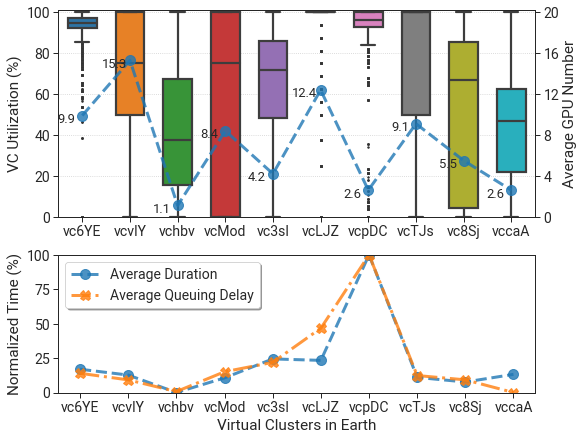

In [5]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=12.5,
        )


def box_vc_utilization(cluster, save):
    fig, (ax1, ax2) = plt.subplots(
        ncols=1,
        nrows=2,
        gridspec_kw={"height_ratios": [1.5, 1]},
        constrained_layout=True,
        figsize=(8, 6),
    )
    df = pd.read_csv(f"./Earth_vcs/Earth_gpu_number.csv")
    parts = df.drop(
        columns=[
            "vc4om",
            "vcVP5",
            "vchA3",
            "vcIya",
            "vcxS0",
            "vc7hD",
            "vcXrB",
            "vcvcM",
            "vcp4O",
            "total",
        ]
    ).iloc[30]
    parts = parts[1:]
    parts = parts.sort_values(ascending=False)[:10]
    parts = parts.index.tolist()

    log = pd.read_csv(
        f"./Earth_vcs/Earth_log.csv",
        parse_dates=["submit_time", "start_time", "end_time"],
    )
    glog = log[log["gpu_num"] > 0]
    glog = glog[glog["vc"].isin(parts)]
    vcgpu = glog.groupby("vc").mean()["gpu_num"]
    vcgpu = vcgpu.loc[parts]
    vcgpu = vcgpu.values
    vcgpu = [round(i, 1) for i in vcgpu]

    df = pd.DataFrame()

    for i, part in enumerate(parts):
        pseq = pd.read_csv(f"./Earth_vcs/{part}/cluster_sequence_vc.csv")
        pseq = pseq.set_index("time")
        pseq["gpu_utilization"] = pseq["gpu_utilization"] * 100
        pseq["vc"] = part
        df = pd.concat([df, pseq[["vc", "gpu_utilization"]]])

    # Filter May 10th
    df.index = pd.to_datetime(df.index)
    df = df[df.index.day != 10]

    flierprops = dict(marker=".", markerfacecolor="k", markersize=3, linestyle="none")
    sns.boxplot(
        x="vc",
        y="gpu_utilization",
        data=df,
        flierprops=flierprops,
        width=0.6,
        linewidth=2.2,
        saturation=0.8,
        palette="tab10",
        ax=ax1,
    )
    sns.color_palette("tab10")
    ax1.set_xlabel(None)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
    ax1.set_ylabel(f"VC Utilization (%)")
    ax1.set_ylim(0, 101)
    ax1.grid(axis="y", linestyle=":")

    glog["qrate"] = 0
    glog["qrate"].loc[glog["queue"] > 0] = 1
    que = glog.groupby("vc").mean()
    que = que[que["queue"] > 0]
    que = que.loc[parts]
    que = que[["queue", "duration"]]
    que = (que - que.min()) / (que.max() - que.min()) * 100
    dur = que["duration"].astype("int")

    ax3 = ax1.twinx()
    ax3.plot(que.index, vcgpu, "--o", alpha=0.8, label="Average Duration")
    ax3.set_ylabel(f"Average GPU Number")
    ax3.set_yticks(np.arange(0, 21, 4))
    ax3.set_ylim(0, 20.2, 1)

    for i in range(len(vcgpu)):
        ax3.annotate(
            vcgpu[i],
            xy=(i, vcgpu[i]),
            xytext=(-16, -10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=13,
        )

    ax2.plot(que.index, que["duration"], "--o", alpha=0.8, label="Average Duration")
    ax2.plot(que.index, que["queue"], "-.X", alpha=0.8, label="Average Queuing Delay")

    ax2.set_xlabel(f"Virtual Clusters in {cluster}")
    ax2.set_ylabel(f"Normalized Time (%)")
    ax2.set_ylim(0, 100)
    ax2.legend(loc="upper left", ncol=1, fancybox=True, shadow=True, fontsize=14)

    if save:
        fig.savefig(f"./vc_utilization.pdf", bbox_inches="tight", dpi=600)


box_vc_utilization("Earth", save=True)